In [45]:
import psycopg2
import matplotlib.pyplot as plt

In [50]:
conn = psycopg2.connect("dbname=project user=hugens")
cursor_psql = conn.cursor()

In [51]:
#scale = 1/30000
scale = 1

In [52]:
sql = "select st_astext(point) from stops"
cursor_psql.execute(sql)
results = cursor_psql.fetchall()
#results

In [53]:
xs_stops = []
ys_stops = []
for row in results:
    point_string = row[0]
    point_string = point_string[6:-1]
    (x,y) = point_string.split()
    xs_stops.append(float(x))
    ys_stops.append(float(y))
print(xs_stops[:5])
print(ys_stops[:5])

[-8.5288333, -8.5588777, -8.5297784, -8.53830549, -8.53824995]
[41.20608334, 41.21944054, 41.20899437, 41.21027777, 41.21016667]


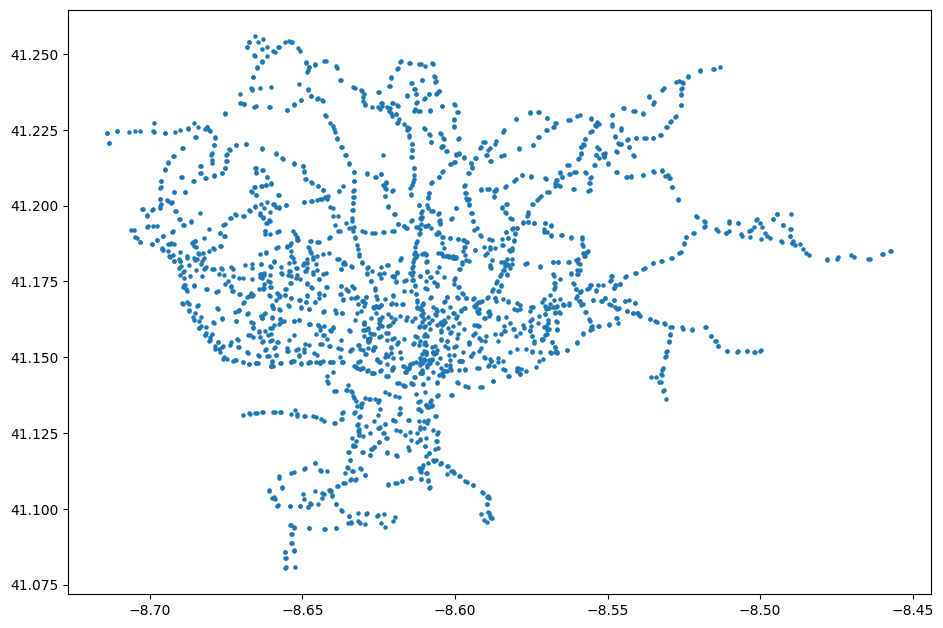

In [54]:
width_in_inches = ((max(xs_stops)-min(xs_stops))/0.0254)*1.1
height_in_inches = ((max(ys_stops)-min(ys_stops))/0.0254)*1.1
fig = plt.figure(figsize=(width_in_inches*scale, height_in_inches*scale))
plt.scatter(xs,ys,s=5)